## Mobilnet with Transfer Learning

## Import Libraries

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import tensorflow as tf
from tensorflow import keras
from keras.layers import *
from sklearn.metrics import confusion_matrix

## Upload Dataset

In [2]:
data_dir = Path.cwd() / 'img_datasetV2'

In [3]:
train_ds = keras.utils.image_dataset_from_directory(
    data_dir, #Directory where the data is located
    labels="inferred", #labels are generated from the directory structure
    label_mode="int", #means that the labels are encoded as integers
    class_names=None, #This is the explicit list of class names
    color_mode="rgb", #Whether the images will be converted to have 1, 3, or 4 channels
    batch_size=64, # Size of the batches of data
    #image_size=(1570, 320), #Size to resize images to after they are read from disk
    shuffle=True, #Whether to shuffle the data
    seed=123, #Optional random seed for shuffling and transformations
    subset="training", #Subset of the data to return. One of "training", "validation", 
    validation_split= 0.2, #Optional float between 0 and 1, fraction of data to reserve for validation.
    interpolation="bilinear", #the interpolation method used when resizing images
    follow_links=False, #Whether to visit subdirectories pointed to by symlinks.
    verbose=True, #Whether to display number information on classes and number of files found.
)

Found 86225 files belonging to 7 classes.
Using 68980 files for training.


In [4]:
val_ds = keras.utils.image_dataset_from_directory(
    data_dir, #Directory where the data is located
    labels="inferred", #labels are generated from the directory structure
    label_mode="int", #means that the labels are encoded as integers
    class_names=None, #This is the explicit list of class names
    color_mode="rgb", #Whether the images will be converted to have 1, 3, or 4 channels
    batch_size=64, # Size of the batches of data
    #image_size=(1570, 320), #Size to resize images to after they are read from disk
    shuffle=True, #Whether to shuffle the data
    seed=123, #Optional random seed for shuffling and transformations
    subset="validation", #Subset of the data to return. One of "training", "validation", 
    validation_split= 0.2, #Optional float between 0 and 1, fraction of data to reserve for validation.
    interpolation="bilinear", #the interpolation method used when resizing images
    follow_links=False, #Whether to visit subdirectories pointed to by symlinks.
    verbose=True, #Whether to display number information on classes and number of files found.
)

Found 86225 files belonging to 7 classes.
Using 17245 files for validation.


## Data Sample

In [5]:
train_ds.class_names

['Cubic',
 'Hexagonal',
 'Monoclinic',
 'Orthorhombic',
 'Tetragonal',
 'Triclinic',
 'Trigonal']

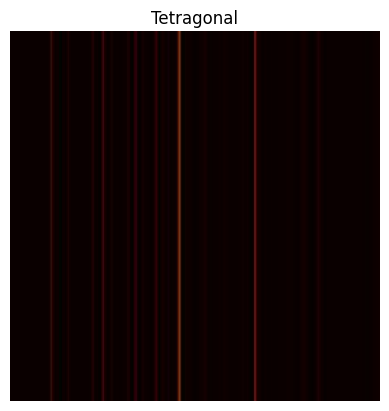

In [6]:
#Show the first nine images and labels from the training set:
class_names = train_ds.class_names

fig, ax = plt.subplots()
for images, labels in train_ds.take(1):
  for i in range(9):
    ax.imshow(images[i].numpy().astype("uint8"))
    ax.set_title(class_names[labels[i]])
    ax.axis("off")

In [7]:
images.shape

TensorShape([64, 256, 256, 3])

## Model Definition

### Base MobilNet model

In [8]:

IMG_WIDTH, IMG_HEIGHT = 256, 256

# Load pre-trained MobileNetV2 model without top layers
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_WIDTH, IMG_HEIGHT, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze the convolutional base before training
base_model.trainable = False

# Input layer
inputs = keras.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))

# Normalize images to expected interval
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)

# Extract features using MobileNetV2
x = base_model(x, training=False)  # Keep batch normalization in inference mode

# Global average pooling
x = GlobalAveragePooling2D()(x)

# Fully connected layers
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)  # Prevent overfitting

# Output layer (7 classes)
outputs = Dense(7, activation='softmax')(x)

# Define model
model = keras.Model(inputs, outputs)

# Print model summary
model.summary()

C:\Users\juliana\AppData\Local\Temp\ipykernel_10360\2957565631.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 8, 8, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        81,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,340,423 (8.93 MB)

 Trainable params: 82,439 (322.03 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

### Compile the Model

In [24]:
LEARNING_RATE = 0.0001

model.compile(optimizer= keras.optimizers.Adam(learning_rate=LEARNING_RATE),
              #Computes the crossentropy loss between the labels and predictions.
              loss= keras.losses.SparseCategoricalCrossentropy(),

              #Calculates how often predictions match integer labels.
              metrics=[keras.metrics.SparseCategoricalAccuracy()]
             )


#Early stopping
callback = keras.callbacks.EarlyStopping(monitor="val_loss", #Quantity to be monitored.
                                         min_delta=0, # Minimum change in the monitored quantity to qualify as an improvement
                                         patience=10, # Number of epochs with no improvement after which training will be stopped.
                                         verbose=1, #mode 1 displays messages when the callback takes an action
                                         mode="min", #n min mode, training will stop when the quantity monitored has stopped decreasing
                                         restore_best_weights=True)

### Train the Model

In [10]:
history = model.fit(train_ds,
                    epochs= 15,
                    validation_data=val_ds,
                    callbacks=[callback])

Epoch 1/15
1078/1078 ━━━━━━━━━━━━━━━━━━━━ 2224s 2s/step - loss: 1.7490 - sparse_categorical_accuracy: 0.3038 - val_loss: 1.4935 - val_sparse_categorical_accuracy: 0.4142
Epoch 2/15
1078/1078 ━━━━━━━━━━━━━━━━━━━━ 2051s 2s/step - loss: 1.5355 - sparse_categorical_accuracy: 0.3888 - val_loss: 1.4202 - val_sparse_categorical_accuracy: 0.4411
Epoch 3/15
1078/1078 ━━━━━━━━━━━━━━━━━━━━ 2068s 2s/step - loss: 1.4735 - sparse_categorical_accuracy: 0.4122 - val_loss: 1.3785 - val_sparse_categorical_accuracy: 0.4560
Epoch 4/15
1078/1078 ━━━━━━━━━━━━━━━━━━━━ 2086s 2s/step - loss: 1.4330 - sparse_categorical_accuracy: 0.4270 - val_loss: 1.3516 - val_sparse_categorical_accuracy: 0.4654
Epoch 5/15
1078/1078 ━━━━━━━━━━━━━━━━━━━━ 2063s 2s/step - loss: 1.4092 - sparse_categorical_accuracy: 0.4398 - val_loss: 1.3304 - val_sparse_categorical_accuracy: 0.4743
Epoch 6/15
1078/1078 ━━━━━━━━━━━━━━━━━━━━ 2063s 2s/step - loss: 1.3870 - sparse_categorical_accuracy: 0.4496 - val_loss: 1.3159 - val_sparse_categoric

### Un-freeze the top layers of the model

Note: This should only be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will forget what it has learned. 
Taken from [Transfer Learning Tutorial](https://www.tensorflow.org/tutorials/images/transfer_learning)

In [20]:
base_model.trainable = True

# Fine-tune
#fine_tune_at = len(base_model.layers) // 3

# Freeze all the layers before the `fine_tune_at` layer
#for layer in base_model.layers[:fine_tune_at]:
  #layer.trainable = False

In [25]:
model.compile(optimizer= keras.optimizers.Adam(learning_rate=LEARNING_RATE),
              #Computes the crossentropy loss between the labels and predictions.
              loss= keras.losses.SparseCategoricalCrossentropy(),

              #Calculates how often predictions match integer labels.
              metrics=[keras.metrics.SparseCategoricalAccuracy(name='accuracy')]
             )

In [27]:
history_fine = model.fit(train_ds,
                         epochs=24,
                         initial_epoch=len(history.epoch),
                         validation_data=val_ds)

Epoch 16/24
1078/1078 ━━━━━━━━━━━━━━━━━━━━ 4470s 4s/step - accuracy: 0.5970 - loss: 1.0107 - val_accuracy: 0.5395 - val_loss: 1.2401
Epoch 17/24
1078/1078 ━━━━━━━━━━━━━━━━━━━━ 4569s 4s/step - accuracy: 0.6095 - loss: 0.9965 - val_accuracy: 0.5769 - val_loss: 1.1123
Epoch 18/24
1078/1078 ━━━━━━━━━━━━━━━━━━━━ 4537s 4s/step - accuracy: 0.6354 - loss: 0.9294 - val_accuracy: 0.5336 - val_loss: 1.3297
Epoch 19/24
1078/1078 ━━━━━━━━━━━━━━━━━━━━ 4735s 4s/step - accuracy: 0.6636 - loss: 0.8472 - val_accuracy: 0.5200 - val_loss: 1.4027
Epoch 20/24
1078/1078 ━━━━━━━━━━━━━━━━━━━━ 4579s 4s/step - accuracy: 0.6962 - loss: 0.7741 - val_accuracy: 0.5636 - val_loss: 1.2410
Epoch 21/24
1078/1078 ━━━━━━━━━━━━━━━━━━━━ 4653s 4s/step - accuracy: 0.7229 - loss: 0.7052 - val_accuracy: 0.5905 - val_loss: 1.1611
Epoch 22/24
1078/1078 ━━━━━━━━━━━━━━━━━━━━ 4218s 4s/step - accuracy: 0.7522 - loss: 0.6378 - val_accuracy: 0.5845 - val_loss: 1.2963
Epoch 23/24
1078/1078 ━━━━━━━━━━━━━━━━━━━━ 4183s 4s/step - accuracy: 

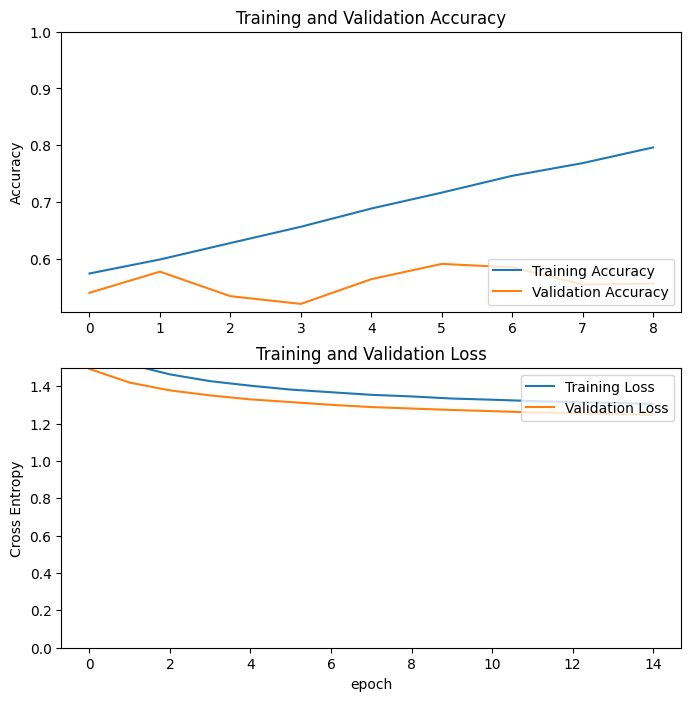

In [28]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

# Access loss and validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.5])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Save the Model

In [29]:
model.save('model_mobilnet.keras')

In [30]:
history_fine = model.fit(train_ds,
                         epochs=30,
                         initial_epoch=24,
                         validation_data=val_ds)

Epoch 25/30
1078/1078 ━━━━━━━━━━━━━━━━━━━━ 4140s 4s/step - accuracy: 0.8213 - loss: 0.4673 - val_accuracy: 0.5699 - val_loss: 1.5667
Epoch 26/30
1078/1078 ━━━━━━━━━━━━━━━━━━━━ 4138s 4s/step - accuracy: 0.8366 - loss: 0.4270 - val_accuracy: 0.5494 - val_loss: 1.9827
Epoch 27/30
1078/1078 ━━━━━━━━━━━━━━━━━━━━ 4626s 4s/step - accuracy: 0.8540 - loss: 0.3911 - val_accuracy: 0.5429 - val_loss: 1.8937
Epoch 28/30
1078/1078 ━━━━━━━━━━━━━━━━━━━━ 4797s 4s/step - accuracy: 0.8697 - loss: 0.3522 - val_accuracy: 0.5621 - val_loss: 1.9309
Epoch 29/30
 136/1078 ━━━━━━━━━━━━━━━━━━━━ 1:11:17 5s/step - accuracy: 0.8842 - loss: 0.3113

KeyboardInterrupt: 

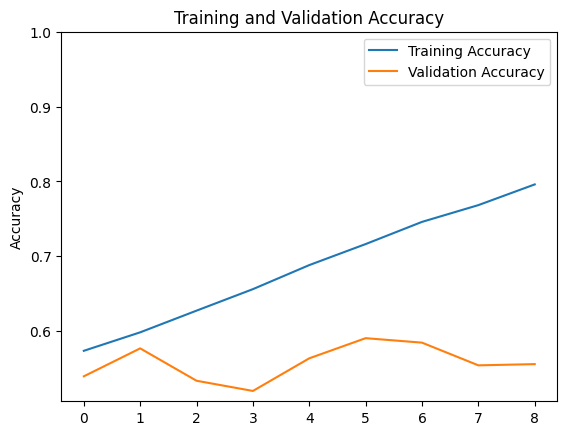

In [39]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

# Access loss and validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure()
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.savefig('training.png')

## Test an Image

Predictions:
 [0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0
 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0
 1 0 0 0]
Labels:
 [2 5 3 5 6 4 3 0 2 6 5 0 3 4 3 2 4 3 1 2 3 5 2 3 5 5 0 0 2 4 4 3 6 

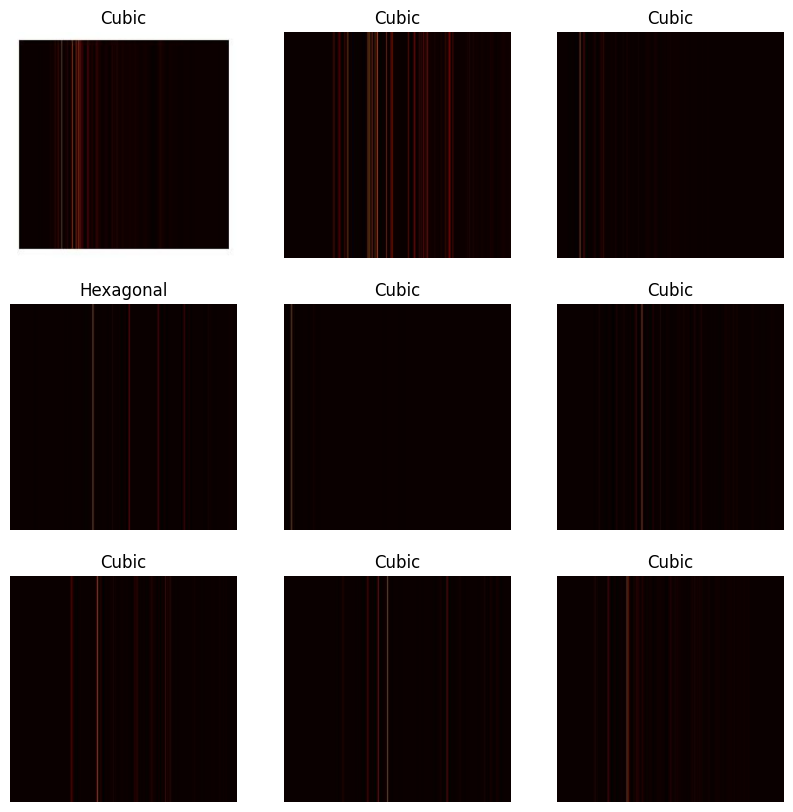

In [31]:
# Retrieve a batch of images from the test set
image_batch, label_batch = val_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

## Analyzing the Results

## Confusion matrix

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 780ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 754ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 736ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 790ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 724ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 747ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 825ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 944ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 796ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 753ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 837ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 859ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 760ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 797ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 794ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 820ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 758ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 804ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 

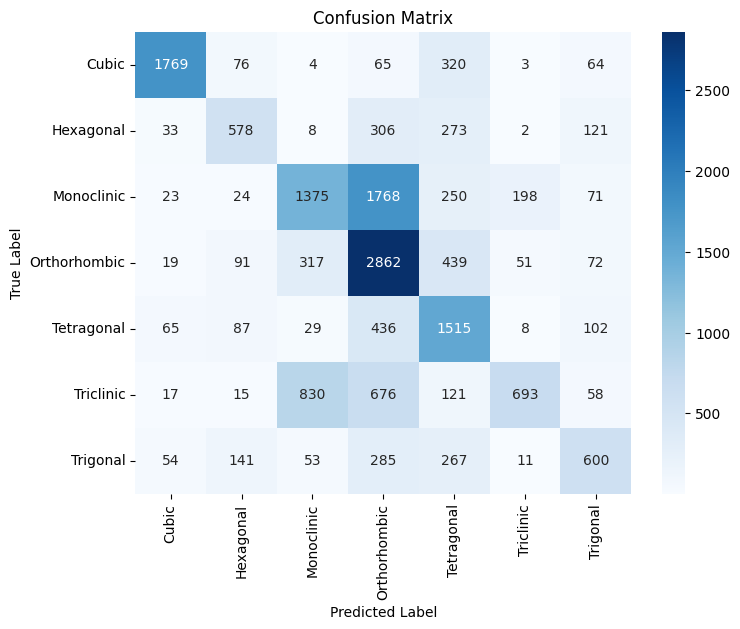

              precision    recall  f1-score   support

       Cubic       0.89      0.77      0.83      2301
   Hexagonal       0.57      0.44      0.50      1321
  Monoclinic       0.53      0.37      0.43      3709
Orthorhombic       0.45      0.74      0.56      3851
  Tetragonal       0.48      0.68      0.56      2242
   Triclinic       0.72      0.29      0.41      2410
    Trigonal       0.55      0.43      0.48      1411

    accuracy                           0.54     17245
   macro avg       0.60      0.53      0.54     17245
weighted avg       0.58      0.54      0.54     17245



In [32]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Extract images and labels from the dataset
y_true = []
y_pred = []

for image_batch, label_batch in val_ds:
    # Store true labels
    y_true.extend(label_batch.numpy())

    # Predict labels
    predictions = model.predict(image_batch)
    y_pred.extend(np.argmax(predictions, axis=1))  # Convert softmax output to class index

# Convert lists to NumPy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=val_ds.class_names, yticklabels=val_ds.class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


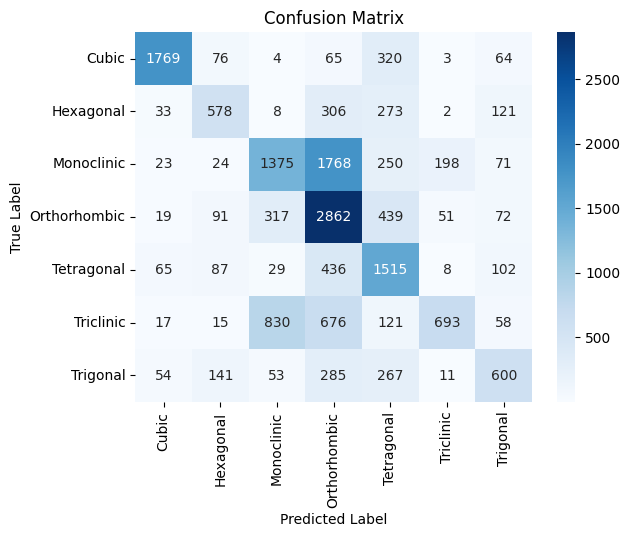

In [40]:
plt.figure()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=val_ds.class_names, yticklabels=val_ds.class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.savefig('conf.jpg')
plt.show()

In [45]:
# Print a classification report for detailed metrics
report = classification_report(y_true, y_pred, target_names=val_ds.class_names, 
                              output_dict=True)
print(report)

{'Cubic': {'precision': 0.8934343434343435, 'recall': 0.7687961755758366, 'f1-score': 0.8264424199953282, 'support': 2301.0}, 'Hexagonal': {'precision': 0.5711462450592886, 'recall': 0.4375473126419379, 'f1-score': 0.4954993570510073, 'support': 1321.0}, 'Monoclinic': {'precision': 0.525611620795107, 'recall': 0.37071987058506334, 'f1-score': 0.43478260869565216, 'support': 3709.0}, 'Orthorhombic': {'precision': 0.44732728977805564, 'recall': 0.7431835886782654, 'f1-score': 0.5584935115621036, 'support': 3851.0}, 'Tetragonal': {'precision': 0.47566718995290425, 'recall': 0.6757359500446031, 'f1-score': 0.5583195135433942, 'support': 2242.0}, 'Triclinic': {'precision': 0.717391304347826, 'recall': 0.287551867219917, 'f1-score': 0.41054502369668244, 'support': 2410.0}, 'Trigonal': {'precision': 0.5514705882352942, 'recall': 0.42523033309709424, 'f1-score': 0.4801920768307323, 'support': 1411.0}, 'accuracy': 0.5446216294578139, 'macro avg': {'precision': 0.5974355116575456, 'recall': 0.52

In [51]:
print(classification_report(y_true, y_pred, target_names=val_ds.class_names))

              precision    recall  f1-score   support

       Cubic       0.89      0.77      0.83      2301
   Hexagonal       0.57      0.44      0.50      1321
  Monoclinic       0.53      0.37      0.43      3709
Orthorhombic       0.45      0.74      0.56      3851
  Tetragonal       0.48      0.68      0.56      2242
   Triclinic       0.72      0.29      0.41      2410
    Trigonal       0.55      0.43      0.48      1411

    accuracy                           0.54     17245
   macro avg       0.60      0.53      0.54     17245
weighted avg       0.58      0.54      0.54     17245



In [48]:
report = pd.DataFrame(report)

In [49]:
report

,Cubic,Hexagonal,Monoclinic,Orthorhombic,Tetragonal,Triclinic,Trigonal,accuracy,macro avg,weighted avg
precision,0.893434,0.571146,0.525612,0.447327,0.475667,0.717391,0.551471,0.544622,0.597436,0.583120
recall,0.768796,0.437547,0.370720,0.743184,0.675736,0.287552,0.425230,0.544622,0.529824,0.544622
f1-score,0.826442,0.495499,0.434783,0.558494,0.558320,0.410545,0.480192,0.544622,0.537754,0.535708
support,2301.000000,1321.000000,3709.000000,3851.000000,2242.000000,2410.000000,1411.000000,0.544622,17245.000000,17245.000000
